### My solution notebook for the Kaggle Titanic competition. Also my first ever try at this, so the code is probably terrible.

In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.impute import KNNImputer, SimpleImputer
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [426]:
data_raw = pd.read_csv("train.csv") # Raw training data
combined = data_raw.copy()
target = data_raw.pop("Survived") # Remove target values from training data

test = pd.read_csv("test.csv") # Raw testing data from which final predictions are made from

# Remove some data that is most likely not relevant to the predictions
data_raw.pop("PassengerId")
data_raw.pop("Ticket")
data_raw.pop("Cabin")

pass_ids_test = test.pop("PassengerId") # Save passenger ids for later
test.pop("Ticket")
test.pop("Cabin")

# Convert sex to numeric values immediately, as we're sure they're correlated to survival
data_raw.replace(["male", "female"], [0, 1], inplace=True) 
test.replace(["male", "female"], [0, 1], inplace=True)

In [427]:
pclass_survival_ratio = combined[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)
sex_survival_ratio = combined[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)
print(f"""{pclass_survival_ratio}

{sex_survival_ratio}""")
# Strong correlation with passenger class and survival / sex and survival.

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [428]:
 # Engineer a new "family size" feature from siblings/spouses + parents/children
data_raw["Family_Size"] = data_raw["SibSp"] + data_raw["Parch"]
test["Family_Size"] = test["SibSp"] + test["Parch"]

In [429]:
data_raw.describe(include=["O"])

,Name,Embarked
count,891,889
unique,891,3
top,"Wick, Mrs. George Dennick (Mary Hitchcock)",S
freq,1,644


In [430]:
test.replace(["C", "Q", "S"], [0, 1, 2], inplace=True)
data_raw.replace(["C", "Q", "S"], [0, 1, 2], inplace=True)

In [431]:
data_raw["Title"] = data_raw.Name.str.extract("([A-Za-z]+)\.", expand=False) # Extract all titles from names and create a new column of them
test["Title"] = test.Name.str.extract("([A-Za-z]+)\.", expand=False)
pd.crosstab(data_raw["Title"], data_raw["Sex"])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [432]:
# Replace rare titles with a new title and replace common titles with the same meaning name
data_raw["Title"] = data_raw["Title"].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data_raw["Title"] = data_raw["Title"].replace(['Mlle', "Ms", "Mme"], ["Miss", "Miss", "Mrs"])
test["Title"] = test["Title"].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test["Title"] = test["Title"].replace(['Mlle', "Ms", "Mme"], ["Miss", "Miss", "Mrs"])
data_raw["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [433]:
# Map newly extracted and modified titles to numerical equivalents
title_mapping = { "Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5 }
data_raw["Title"] = data_raw["Title"].map(title_mapping)
data_raw["Title"] = data_raw["Title"].fillna(0)
test["Title"] = test["Title"].map(title_mapping)
test["Title"] = test["Title"].fillna(0)
data_raw["Title"].head()

0    1
1    3
2    2
3    3
4    1
Name: Title, dtype: int64

In [434]:
# After having engineered the new title feature, lets remove the names
test.drop("Name", axis=1, inplace=True)
data_raw.drop("Name", axis=1, inplace=True)

In [435]:
data_raw.isnull().sum() # Null values in raw training data

Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
Family_Size      0
Title            0
dtype: int64

In [436]:
data_raw.describe() # Statistics of raw training data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_Size,Title
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000,891.000000,891.000000
mean,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,1.535433,0.904602,1.728395
std,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.792088,1.613459,1.030039
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000,0.000000,1.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,2.000000,0.000000,1.000000
75%,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000,1.000000,2.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,10.000000,5.000000


In [437]:
data_raw.head() # First five samples of raw data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_Size,Title
0,3,0,22.0,1,0,7.2500,2.0,1,1
1,1,1,38.0,1,0,71.2833,0.0,1,3
2,3,1,26.0,0,0,7.9250,2.0,0,2
3,1,1,35.0,1,0,53.1000,2.0,1,3
4,3,0,35.0,0,0,8.0500,2.0,0,1


In [438]:
# Impute missing numeric values with nearest neighbour values with most frequent value in column
knnimputer = KNNImputer(missing_values=np.nan, n_neighbors=3)
data_raw["Age"] = knnimputer.fit_transform(data_raw["Age"].values.reshape(-1, 1))
data_raw["Embarked"] = knnimputer.fit_transform(data_raw["Embarked"].values.reshape(-1, 1))
test["Age"] = knnimputer.fit_transform(test["Age"].values.reshape(-1, 1))
test["Fare"] = knnimputer.fit_transform(test["Age"].values.reshape(-1, 1))

In [439]:
data_raw.isnull().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family_Size    0
Title          0
dtype: int64

In [440]:
test.isnull().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family_Size    0
Title          0
dtype: int64

## Finding possible outliers.

<AxesSubplot:xlabel='Fare'>

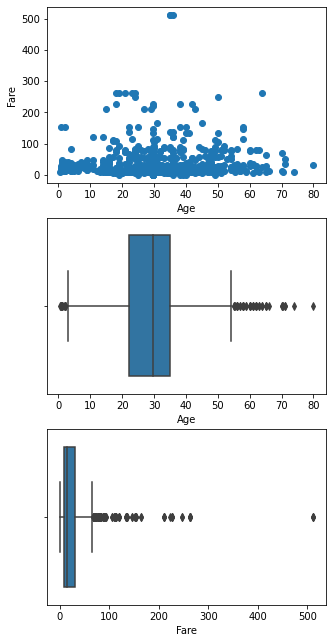

In [441]:
ages = data_raw["Age"]
fares = data_raw["Fare"]

figure, axes = plt.subplots(3, 1, figsize=(5, 11))
axes[0].scatter(ages, fares)
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Fare")
sb.boxplot(ax=axes[1], x=ages)
sb.boxplot(ax=axes[2], x=fares)

In [442]:
zscores = np.abs(stats.zscore(fares))
thresholded = np.argwhere(zscores > 3) # Indices of Z-Scores where the score is above a certain threshold
len(thresholded)

20

### As you can see from the plots and calculate Z-Scores above, it seems there are some significant outliers in the Fare column.

In [443]:
fares_mean = np.mean(fares)
fares = [fares_mean if i in thresholded else j for i, j in enumerate(fares)] # Replace the detected outlier fares with mean fares

<AxesSubplot:>

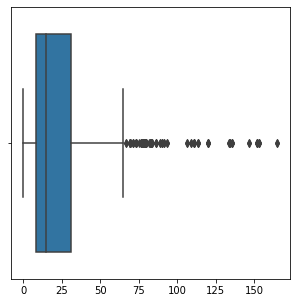

In [444]:
figure, axes = plt.subplots(1, 1, figsize=(5, 5)) 
sb.boxplot(ax=axes, x=fares) # Plot of the most significant outliers removed

In [445]:
data_raw["Fare"] = fares

In [446]:
data_raw.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_Size,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.699118,0.523008,0.381594,26.657534,1.535433,0.904602,1.728395
std,0.836071,0.477990,13.002015,1.102743,0.806057,29.031704,0.791197,1.613459,1.030039
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,1.000000
50%,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,2.000000,0.000000,1.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,2.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,164.866700,2.000000,10.000000,5.000000


In [447]:
X_train, X_test, y_train, y_test = train_test_split(data_raw, target, test_size=0.15, stratify=target)

In [448]:
# Create many RF classifiers with different amount of estimators
rfcs = []
for i in range(1, 101):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X_train, y_train)
    rfcs.append(rfc)
    
# Calculate scores for each RFC to try to find the "best" (by accuracy)
rfcs_accs = []
for rfc in rfcs:
    accuracy = rfc.score(X_test, y_test)
    rfcs_accs.append((accuracy, rfc.n_estimators, rfc))
rfcs_accs = sorted(rfcs_accs, key=lambda x: x[0])
best_rfc_tuple = rfcs_accs[len(rfcs_accs) - 1]
print(best_rfc_tuple) # Best rated RFC

(0.8955223880597015, 67, RandomForestClassifier(n_estimators=67))


In [449]:
# Create many KNN classifiers with different amount of estimators
knncs = []
for i in range(1, 51):
    knnc = KNeighborsClassifier(n_neighbors=i)
    knnc.fit(X_train, y_train)
    knncs.append(knnc)
    
# Calculate scores for each KNNC to try to find the "best" (by accuracy)
knnc_accs = []
for knnc in knncs:
    accuracy = knnc.score(X_test, y_test)
    knnc_accs.append((accuracy, knnc.n_neighbors, knnc))
knnc_accs = sorted(knnc_accs, key=lambda x: x[0])
best_knnc_tuple = knnc_accs[len(knnc_accs) - 1]
print(best_knnc_tuple) # Best rated KNNC

(0.8208955223880597, 9, KNeighborsClassifier(n_neighbors=9))


In [450]:
# Create many AdaBoost classifiers with different amount of estimators
adaboostcs = []
for i in range(1, 101):
    adaboostc = AdaBoostClassifier(n_estimators=i)
    adaboostc.fit(X_train, y_train)
    adaboostcs.append(adaboostc)
    
# Calculate scores for each AdaBoost classifieer to try to find the "best" (by accuracy)
adaboostc_accs = []
for adaboostc in adaboostcs:
    accuracy = adaboostc.score(X_test, y_test)
    adaboostc_accs.append((accuracy, adaboostc.n_estimators, adaboostc))
adaboostc_accs = sorted(adaboostc_accs, key=lambda x: x[0])
best_adaboostc_tuple = adaboostc_accs[len(adaboostc_accs) - 1]
print(best_adaboostc_tuple) # Best rated AdaBoost classifier

(0.8955223880597015, 100, AdaBoostClassifier(n_estimators=100))


In [451]:
clfs = [best_rfc_tuple, best_knnc_tuple, best_adaboostc_tuple]
clfs = sorted(clfs, key=lambda x: x[0])
final_clf = clfs[len(clfs) - 1][2]
print(f"Final classifier type: {type(final_clf)}")
prediction = final_clf.predict(test)

Final classifier type: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>


In [452]:
data = { "PassengerId" : pass_ids_test, "Survived": prediction }
result = pd.DataFrame(data)
result.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.401914
std,120.810458,0.490872
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [453]:
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,1


In [454]:
result.to_csv("result.csv", index=False)